In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import lime
import lime.lime_tabular
import pickle
import json
from joblib import Parallel, delayed
import os
from datetime import datetime
from IPython.display import HTML, display
import matplotlib.pyplot as plt


# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', module='xgboost')
warnings.filterwarnings('ignore', module='lightgbm')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# Create models directory if it doesn't exist
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

In [30]:
import sys
print(sys.executable)

c:\Users\luffy\Desktop\XAINIDS\.venv\Scripts\python.exe


In [31]:
np.__version__

'2.0.0'

In [32]:
DOCS_DIR = './docs'  
MODEL_DIR = './models'
sample_file = f'{DOCS_DIR}/preprocessed_data.csv'

In [33]:
# === Function to load the scaler, model, and label encoder ===
def load_model(model_name, models_dir="./models"):
    """
    Load the saved scaler, model, and label encoder by name.

    Parameters:
    model_name (str): Name of the model (e.g., 'Random Forest', 'XGBoost')
    models_dir (str): Directory where models are saved

    Returns:
    tuple: (scaler, model, label_encoder)
    """
    # Build file paths
    model_filename = f"{model_name.replace(' ', '_').lower()}.pkl"
    model_path = os.path.join(models_dir, model_filename)
    scaler_path = os.path.join(models_dir, "scaler.pkl")
    label_encoder_path = os.path.join(models_dir, "label_encoder.pkl")

    # Check file existence
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Model file not found: {model_path}")
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"❌ Scaler file not found: {scaler_path}")
    if not os.path.exists(label_encoder_path):
        raise FileNotFoundError(f"❌ LabelEncoder file not found: {label_encoder_path}")

    # Load all artifacts
    scaler = joblib.load(scaler_path)
    model = joblib.load(model_path)
    with open(label_encoder_path, "rb") as f:
        le = pickle.load(f)

    return scaler, model, le

# 💡 Usage example
print("\n💡 To load a saved model, scaler, and label encoder, use:")
print("   scaler, model, le = load_model('Random Forest')")


💡 To load a saved model, scaler, and label encoder, use:
   scaler, model, le = load_model('Random Forest')


In [34]:
df = pd.read_csv(sample_file)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282531 entries, 0 to 282530
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   total_length_of_fwd_packets  282531 non-null  float64
 1   total_length_of_bwd_packets  282531 non-null  float64
 2   fwd_packet_length_max        282531 non-null  float64
 3   bwd_packet_length_max        282531 non-null  float64
 4   bwd_packet_length_mean       282531 non-null  float64
 5   max_packet_length            282531 non-null  float64
 6   packet_length_mean           282531 non-null  float64
 7   packet_length_std            282531 non-null  float64
 8   packet_length_variance       282531 non-null  float64
 9   average_packet_size          282531 non-null  float64
 10  avg_bwd_segment_size         282531 non-null  float64
 11  subflow_fwd_bytes            282531 non-null  float64
 12  subflow_bwd_bytes            282531 non-null  float64
 13 

In [36]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [37]:
x

,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,bwd_packet_length_max,bwd_packet_length_mean,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,average_packet_size,avg_bwd_segment_size,subflow_fwd_bytes,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,264.0,-1.0
1,62.0,208.0,31.0,104.0,104.0,104.0,60.200000,39.983747,1598.700000,75.25,104.0,62.0,208.0,-1.0,-1.0
2,12.0,0.0,6.0,0.0,0.0,6.0,6.000000,0.000000,0.000000,9.00,0.0,12.0,0.0,258.0,-1.0
3,80.0,112.0,40.0,56.0,56.0,56.0,46.400000,8.763561,76.800000,58.00,56.0,80.0,112.0,-1.0,-1.0
4,57.0,173.0,57.0,173.0,173.0,173.0,95.666667,66.972631,4485.333333,143.50,173.0,57.0,173.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282526,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,259.0,247.0
282527,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,304.0,254.0
282528,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,115.0,250.0
282529,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,-1.0


In [38]:
y

0          0
1          0
2          0
3          0
4          0
          ..
282526    11
282527     0
282528     0
282529     0
282530     0
Name: label, Length: 282531, dtype: int64

In [39]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(x) 

# Save the scaler
joblib.dump(scaler, f"{MODEL_DIR}/scaler.pkl")
print("Scaler saved to models/scaler.pkl")


Scaler saved to models/scaler.pkl


In [40]:
X_scaled

array([[-0.09038836, -0.00679726, -0.29083875, ..., -0.00679759,
        -0.46882325, -0.23533674],
       [-0.07986246, -0.00670128, -0.24730745, ..., -0.0067016 ,
        -0.48732847, -0.23533674],
       [-0.08835109, -0.00679726, -0.28241334, ..., -0.00679759,
        -0.46924223, -0.23533674],
       ...,
       [-0.09038836, -0.00679726, -0.29083875, ..., -0.00679759,
        -0.47922807, -0.20556557],
       [-0.09038836, -0.00679726, -0.29083875, ..., -0.00679759,
        -0.48725863, -0.23533674],
       [-0.09038836, -0.00679726, -0.29083875, ..., -0.00679759,
         0.08479698,  1.496491  ]])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [42]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', n_jobs=-1, random_state=42, verbosity=0),
    "LightGBM": LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1, force_col_wise=True)
}

# Sequential training - COMMENTED OUT
# results = []
# model_paths = []
# print("Starting model training and evaluation...\n")
# for name, model in tqdm(models.items(), desc="Overall Progress", unit="model"):
#     result, model_path = train_and_evaluate(name, model, X_train, y_train, X_test, y_test)
#     results.append(result)
#     model_paths.append({"Model": name, "Path": model_path})

# Parallel training with model saving and tracking
def train_and_evaluate_parallel(name, model):
    print(f"Training {name} in parallel...")

    # Handle feature names for LightGBM
    if name == "LightGBM":
        if hasattr(X_train, 'columns'):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        else:
            feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
            X_train_df = pd.DataFrame(X_train, columns=feature_names)
            X_test_df = pd.DataFrame(X_test, columns=feature_names)
            model.fit(X_train_df, y_train)
            y_pred = model.predict(X_test_df)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Save model
    model_filename = f"{name.replace(' ', '_').lower()}.pkl"
    model_path = os.path.join(models_dir, model_filename)
    joblib.dump(model, model_path)

    print(f"✓ {name} completed - Accuracy: {accuracy_score(y_test, y_pred):.4f} - Saved to {model_path}")

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average='macro', zero_division=0),
        "Path": model_path
    }

print("Training models in parallel...\n")
model_items = list(models.items())
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_and_evaluate_parallel)(name, model)
    for name, model in model_items
)

# Extract model paths
model_paths = [{"Model": r["Model"], "Path": r["Path"]} for r in results]

# Display results
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

results_df = pd.DataFrame(results).drop(columns="Path").sort_values(by="Accuracy", ascending=False)
print(results_df.to_string(index=False, float_format='%.4f'))

# Additional summary
print(f"\nBest performing model: {results_df.iloc[0]['Model']}")
print(f"Best accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

# Save results summary
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f"model_evaluation_results.csv"
results_path = os.path.join(models_dir, results_filename)
results_df.to_csv(results_path, index=False)

# Save model paths summary
model_paths_df = pd.DataFrame(model_paths)
paths_filename = f"model_paths.csv"
paths_path = os.path.join(models_dir, paths_filename)
model_paths_df.to_csv(paths_path, index=False)

print(f"\n" + "="*60)
print("SAVED FILES")
print("="*60)
print("Trained models saved:")
for model_info in model_paths:
    print(f"  • {model_info['Model']}: {model_info['Path']}")

print(f"\nResults summary saved to: {results_path}")
print(f"Model paths saved to: {paths_path}")
print(f"\n📁 All files saved in the '{models_dir}' directory")


Training models in parallel...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   17.1s remaining:   34.4s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   41.4s remaining:   20.7s



MODEL EVALUATION RESULTS
              Model  Accuracy  Precision  Recall  F1-Score
      Random Forest    0.9962     0.8735  0.7453    0.7617
      Decision Tree    0.9960     0.7868  0.6987    0.7110
                KNN    0.9956     0.7725  0.7350    0.7388
            XGBoost    0.9951     0.8700  0.7366    0.7393
Logistic Regression    0.9058     0.3396  0.2573    0.2895
           LightGBM    0.7202     0.0944  0.1286    0.1018

Best performing model: Random Forest
Best accuracy: 0.9962

SAVED FILES
Trained models saved:
  • Logistic Regression: models\logistic_regression.pkl
  • KNN: models\knn.pkl
  • Decision Tree: models\decision_tree.pkl
  • Random Forest: models\random_forest.pkl
  • XGBoost: models\xgboost.pkl
  • LightGBM: models\lightgbm.pkl

Results summary saved to: models\model_evaluation_results.csv
Model paths saved to: models\model_paths.csv

📁 All files saved in the 'models' directory


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.0min finished


In [43]:
scaler, model, le = load_model("Random Forest")      # Ensure this path is correct

# === Step 2: Define the input JSON ===
input_json = {
        "total_length_of_fwd_packets": 6.0,
        "total_length_of_bwd_packets": 6.0,
        "fwd_packet_length_max": 6.0,
        "bwd_packet_length_max": 6.0,
        "bwd_packet_length_mean": 6.0,
        "max_packet_length": 6.0,
        "packet_length_mean": 6.0,
        "packet_length_std": 0.0,
        "packet_length_variance": 0.0,
        "average_packet_size": 9.0,
        "avg_bwd_segment_size": 6.0,
        "subflow_fwd_bytes": 6.0,
        "subflow_bwd_bytes": 6.0,
        "init_win_bytes_forward": 237.0,
        "init_win_bytes_backward": 256.0
    }

#### Explaination usinig LIME

In [44]:
# === Normalize & Scaling ===
feature_names = list(input_json.keys())
input_df = pd.DataFrame([input_json])
input_scaled = scaler.transform(input_df)

# === Prediction ===
y_pred = model.predict(input_scaled)
y_proba = model.predict_proba(input_scaled)
predicted_label = y_pred[0]
predicted_class_name = le.inverse_transform([predicted_label])[0]

print(f"🟢 Predicted Class: {predicted_label} ({predicted_class_name})")
print(f"🔢 Prediction Probability: {y_proba[0][predicted_label]:.4f}\n")

print("📊 All Class Probabilities (>1%):")
for i, prob in enumerate(y_proba[0]):
    if prob > 0.01:
        print(f"  {le.inverse_transform([i])[0]:<25}: {prob:.4f}")

# === Generate Synthetic Training Data (only if real unavailable) ===
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)
    return pd.DataFrame([{
        "total_length_of_fwd_packets": np.random.randint(100, 10000),
        "total_length_of_bwd_packets": np.random.randint(1000, 50000),
        "fwd_packet_length_max": np.random.randint(100, 5000),
        "bwd_packet_length_max": np.random.randint(1000, 15000),
        "bwd_packet_length_mean": np.random.uniform(500, 5000),
        "max_packet_length": np.random.randint(1000, 15000),
        "packet_length_mean": np.random.uniform(200, 2000),
        "packet_length_std": np.random.uniform(500, 5000),
        "packet_length_variance": np.random.uniform(1e6, 1e7),
        "average_packet_size": np.random.uniform(200, 2000),
        "avg_bwd_segment_size": np.random.uniform(500, 5000),
        "subflow_fwd_bytes": np.random.randint(100, 10000),
        "subflow_bwd_bytes": np.random.randint(1000, 50000),
        "init_win_bytes_forward": np.random.randint(100, 1000),
        "init_win_bytes_backward": np.random.randint(100, 1000)
    } for _ in range(n_samples)])

training_df = generate_synthetic_data()
training_scaled = scaler.transform(training_df)

# === LIME Explainer ===
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_scaled,
    feature_names=feature_names,
    class_names=list(le.classes_),  # Use LabelEncoder class names
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# === LIME Explanation ===
explanation = explainer.explain_instance(
    input_scaled[0],
    model.predict_proba,
    num_features=len(feature_names),
    top_labels=5
)

🟢 Predicted Class: 1 (Bot)
🔢 Prediction Probability: 0.9797

📊 All Class Probabilities (>1%):
  BENIGN                   : 0.0203
  Bot                      : 0.9797


In [45]:
# === Explanation Display ===
exp_list = explanation.as_list(label=predicted_label)

print("\n🧠 LIME EXPLANATION")
print("-" * 60)
for feat, val in exp_list:
    direction = "↑ increases" if val > 0 else "↓ decreases"
    print(f"{feat:<35} | {val:>7.4f} ({direction} prediction)")




🧠 LIME EXPLANATION
------------------------------------------------------------
bwd_packet_length_mean <= 2.18      |  0.0048 (↑ increases prediction)
avg_bwd_segment_size <= 2.24        |  0.0046 (↑ increases prediction)
bwd_packet_length_max <= 1.77       |  0.0030 (↑ increases prediction)
packet_length_std <= 2.17           | -0.0025 (↓ decreases prediction)
subflow_bwd_bytes <= -0.00          |  0.0021 (↑ increases prediction)
total_length_of_bwd_packets <= -0.00 |  0.0019 (↑ increases prediction)
max_packet_length <= 1.72           | -0.0017 (↓ decreases prediction)
packet_length_variance <= 1.62      |  0.0016 (↑ increases prediction)
init_win_bytes_forward <= -0.46     |  0.0013 (↑ increases prediction)
packet_length_mean <= 1.72          | -0.0013 (↓ decreases prediction)
total_length_of_fwd_packets <= 0.36 |  0.0009 (↑ increases prediction)
fwd_packet_length_max <= 1.56       |  0.0009 (↑ increases prediction)
subflow_fwd_bytes <= 0.35           | -0.0008 (↓ decreases predict

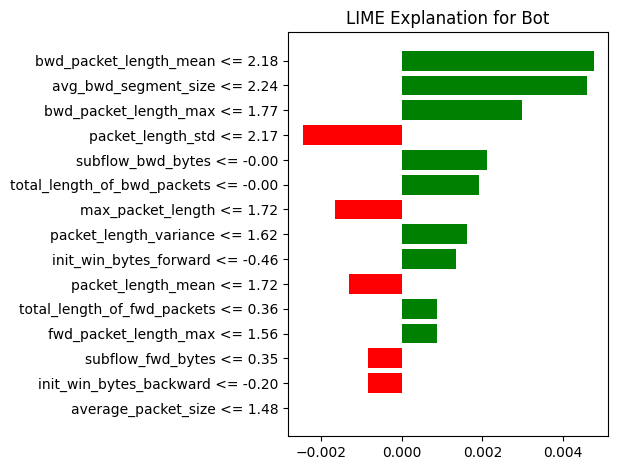

In [46]:
# === Plot LIME ===
fig = explanation.as_pyplot_figure(label=predicted_label)
plt.title(f'LIME Explanation for {predicted_class_name}')
plt.tight_layout()
plt.show()

In [47]:
# === HTML Output with Light Background ===
html_content = explanation.as_html(labels=[predicted_label])

display(HTML(html_content))

In [48]:
# === Summary: Top Contributing Features ===
print("\n🌟 TOP CONTRIBUTING FEATURES")
print("=" * 60)
for i, (feature, importance) in enumerate(sorted(exp_list, key=lambda x: abs(x[1]), reverse=True)[:5], 1):
    status = "SUPPORTS" if importance > 0 else "OPPOSES"
    print(f"{i}. {feature} → {importance:.4f} ({status} prediction)")


🌟 TOP CONTRIBUTING FEATURES
1. bwd_packet_length_mean <= 2.18 → 0.0048 (SUPPORTS prediction)
2. avg_bwd_segment_size <= 2.24 → 0.0046 (SUPPORTS prediction)
3. bwd_packet_length_max <= 1.77 → 0.0030 (SUPPORTS prediction)
4. packet_length_std <= 2.17 → -0.0025 (OPPOSES prediction)
5. subflow_bwd_bytes <= -0.00 → 0.0021 (SUPPORTS prediction)


In [49]:
# === Detailed Feature Impact ===
print("\n🔍 FEATURE VALUE ANALYSIS")
print("=" * 60)
for feat in feature_names:
    value = input_json[feat]
    impact = next((imp for f, imp in exp_list if feat in f), 0)
    print(f"{feat:<35}: {value:>10.2f} | LIME Impact: {impact:>8.4f}")


🔍 FEATURE VALUE ANALYSIS
total_length_of_fwd_packets        :       6.00 | LIME Impact:   0.0009
total_length_of_bwd_packets        :       6.00 | LIME Impact:   0.0019
fwd_packet_length_max              :       6.00 | LIME Impact:   0.0009
bwd_packet_length_max              :       6.00 | LIME Impact:   0.0030
bwd_packet_length_mean             :       6.00 | LIME Impact:   0.0048
max_packet_length                  :       6.00 | LIME Impact:  -0.0017
packet_length_mean                 :       6.00 | LIME Impact:   0.0048
packet_length_std                  :       0.00 | LIME Impact:  -0.0025
packet_length_variance             :       0.00 | LIME Impact:   0.0016
average_packet_size                :       9.00 | LIME Impact:  -0.0000
avg_bwd_segment_size               :       6.00 | LIME Impact:   0.0046
subflow_fwd_bytes                  :       6.00 | LIME Impact:  -0.0008
subflow_bwd_bytes                  :       6.00 | LIME Impact:   0.0021
init_win_bytes_forward             :  

c:\Users\luffy\Desktop\XAINIDS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📌 SHAP EXPLANATION


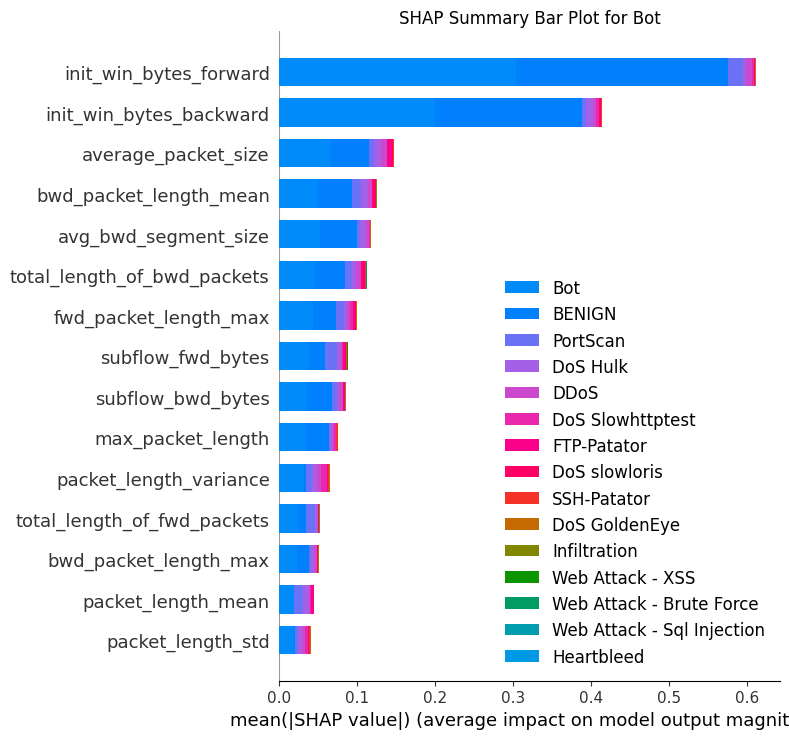

In [51]:
import shap

# === SHAP EXPLANATION ===
print("\n📌 SHAP EXPLANATION")
print("=" * 60)

# Create TreeExplainer and compute SHAP values
explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(input_scaled)

# For multi-class models, shap_values is a list of arrays (one per class)
if isinstance(shap_values, list):
    shap_values_for_pred = shap_values[predicted_label]
    shap_values_train = explainer_shap.shap_values(training_scaled)
    shap_values_train_pred = shap_values_train[predicted_label]
else:
    # For binary classification
    shap_values_for_pred = shap_values
    shap_values_train = explainer_shap.shap_values(training_scaled)
    shap_values_train_pred = shap_values_train

# === SHAP Summary (Top Features) ===
# Use LabelEncoder for class names
class_names = list(le.classes_)

shap.summary_plot(
    shap_values_for_pred,
    input_scaled,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15,
    show=False,
    class_names=class_names
)

plt.title(f'SHAP Summary Bar Plot for {predicted_class_name}')
plt.tight_layout()
plt.show()


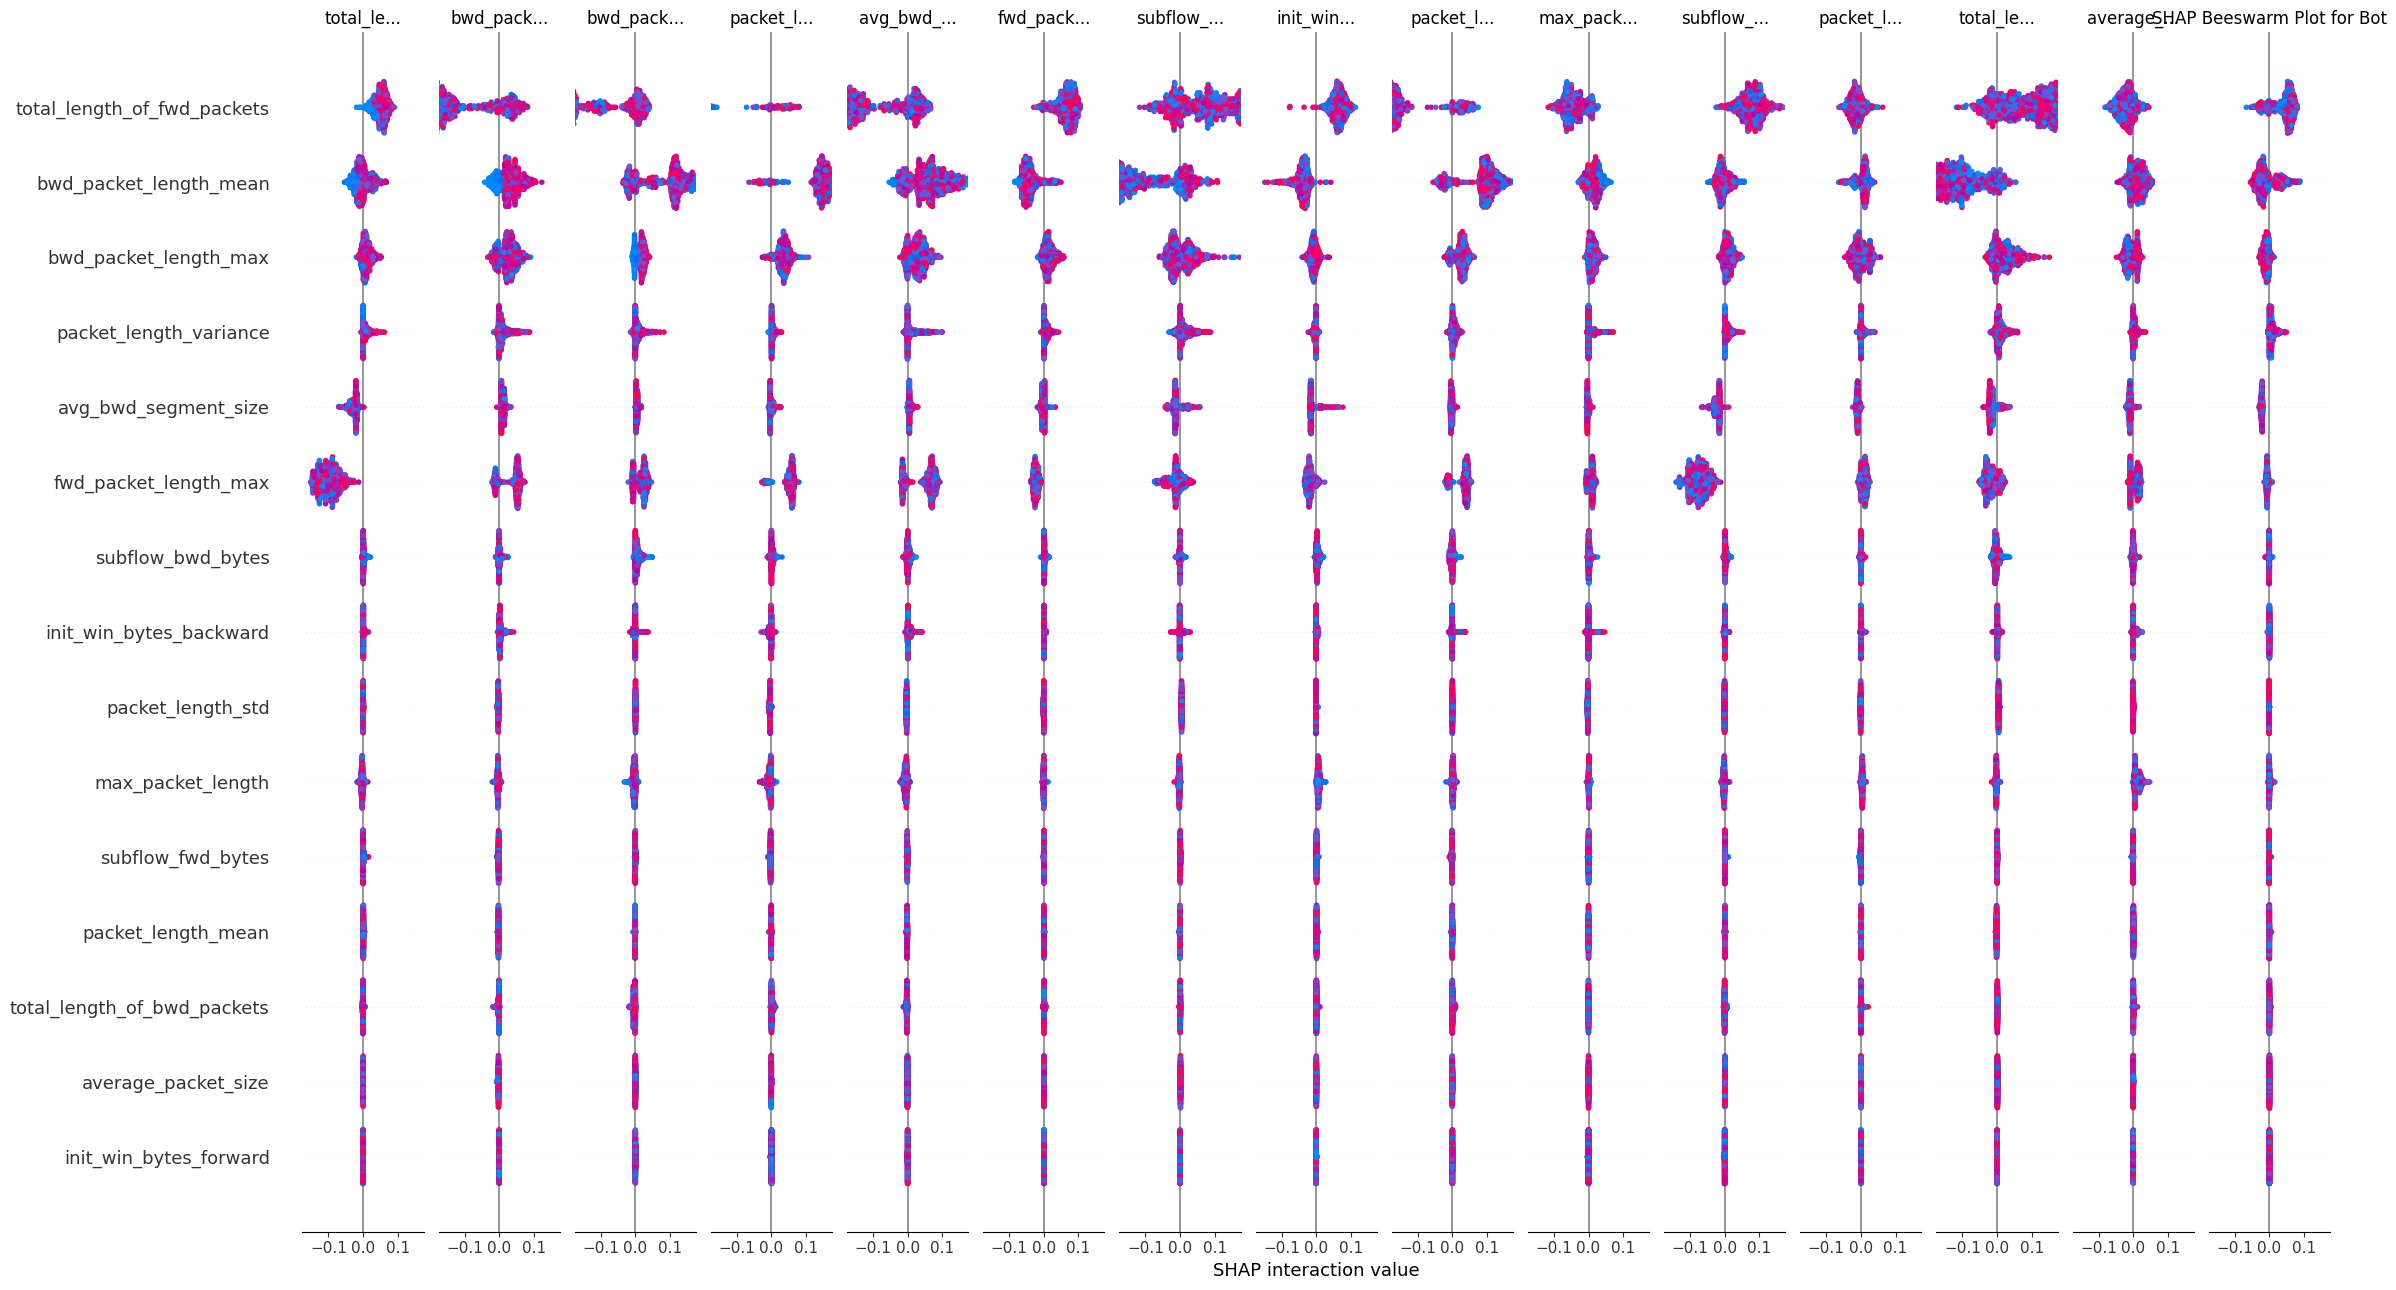

In [ ]:
# === SHAP Beeswarm (training distribution) ===
shap.summary_plot(
    shap_values_train_pred, 
    training_scaled, 
    feature_names=feature_names,
    max_display=15,
    show=False
)
plt.title(f'SHAP Beeswarm Plot for {predicted_class_name}')
plt.tight_layout()
plt.show()

In [ ]:
# === Step 1: Load model, scaler, and label encoder ===
scaler, model, le = load_model("Random Forest")  # le = LabelEncoder

# === Step 2: Load the input JSON data ===
with open(f"{DOCS_DIR}/test.json", "r") as f:
    input_data = json.load(f)

# === Step 3: Function to predict for a single sample ===
def predict_threat(threat_type):
    """Predict threat for a specific sample from the input data"""
    if threat_type not in input_data:
        print(f"❌ Error: '{threat_type}' not found in input data")
        return

    sample_data = input_data[threat_type]
    input_df = pd.DataFrame([sample_data])
    input_scaled = scaler.transform(input_df)

    # Predict
    y_pred = model.predict(input_scaled)
    y_proba = model.predict_proba(input_scaled) if hasattr(model, "predict_proba") else None

    predicted_class = y_pred[0]
    threat_label = le.inverse_transform([predicted_class])[0]

    # Output
    print(f"\n=== Prediction for '{threat_type}' ===")
    print("Predicted Class ID:", predicted_class)
    print("Predicted Threat Type:", threat_label)
    print("Actual Threat Type:", threat_type)
    print("Prediction Correct:", threat_label == threat_type)

    if y_proba is not None:
        print("\nClass Probabilities:")
        for idx, prob in enumerate(y_proba[0]):
            class_name = le.inverse_transform([idx])[0]
            print(f" {idx} - {class_name}: {prob:.4f}")

# === Step 4: Function to predict all samples ===
def predict_all_threats():
    """Predict for all samples in the input data"""
    print("=== Predicting all threat types ===\n")
    for threat_type in input_data.keys():
        predict_threat(threat_type)

# === Step 5: Batch prediction with summary ===
def batch_predict():
    """Convert all samples to DataFrame and predict in batch"""
    samples = []
    labels = []

    for threat_type, features in input_data.items():
        samples.append(features)
        labels.append(threat_type)

    input_df = pd.DataFrame(samples)
    input_scaled = scaler.transform(input_df)

    y_pred = model.predict(input_scaled)
    y_proba = model.predict_proba(input_scaled) if hasattr(model, "predict_proba") else None

    print("\n=== Batch Prediction Results ===")
    for i, (actual, predicted_id) in enumerate(zip(labels, y_pred)):
        predicted_label = le.inverse_transform([predicted_id])[0]
        match = "✓" if actual == predicted_label else "✗"
        print(f"Sample {i+1}: {actual} → Predicted: {predicted_label} (ID: {predicted_id}) - {match}")

        if y_proba is not None:
            top_probs = [
                f"{le.inverse_transform([j])[0]}: {prob:.3f}"
                for j, prob in enumerate(y_proba[i]) if prob > 0.1
            ]
            print("  Top probabilities:", ", ".join(top_probs))

# === Example Usage ===
if __name__ == "__main__":
    # Predict for a single threat type
    predict_threat("Web Attack - XSS")

    # Or predict for all threat types
    # predict_all_threats()

    # Or do batch prediction
    # batch_predict()



=== Prediction for 'Web Attack - XSS' ===
Predicted Class ID: 0
Predicted Threat Type: BENIGN
Actual Threat Type: Web Attack - XSS
Prediction Correct: False

Class Probabilities:
 0 - BENIGN: 0.7112
 1 - Bot: 0.0000
 2 - DDoS: 0.0000
 3 - DoS GoldenEye: 0.0000
 4 - DoS Hulk: 0.0108
 5 - DoS Slowhttptest: 0.0007
 6 - DoS slowloris: 0.0015
 7 - FTP-Patator: 0.0000
 8 - Heartbleed: 0.0000
 9 - Infiltration: 0.0000
 10 - PortScan: 0.0602
 11 - SSH-Patator: 0.0000
 12 - Web Attack - Brute Force: 0.1419
 13 - Web Attack - Sql Injection: 0.0000
 14 - Web Attack - XSS: 0.0737
